# 1  Imports

In [46]:
import pandas as pd
import numpy as np
from enum import Enum, auto
from pylab import plt, mpl
import scipy
from sklearn.linear_model import LinearRegression
# from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

%matplotlib inline
#%matplotlib notebook

# 2  Classes

In [47]:
class Frequency(str, Enum):
    
    SNAP = 'snap'
    MINUTE = 'minute'
    HOURLY = 'hour'
    DAILY = 'daily'

In [48]:
class underChange(float):
    
    fiveBPS = 5 
    tenBPS = 10 
    twentyBPS = 20 
    fiftyBPS = 50 

In [49]:
class Hedger:
    
    def __init__(
        self,
        data: pd.DataFrame,
        date = None,
        t_cost: float = 5.0,
        open_time: str = '13:05',
        close_time: str = '20:50'):

        # initialises values

        self.data = data.copy()
        self.t_cost = t_cost
        self.open_time = open_time
        self.close_time = close_time
        self.prepare_data(date)

    def prepare_data(self, date = None):

        # transforms data into the appropriate form to work with (dont need to change)
            
        self.data.set_index('theo_event_tx_timestamp',inplace=True)
        self.data.index = pd.to_datetime(self.data.index)
        self.data.sort_index(inplace=True)
        self.data = self.data.between_time(self.open_time, self.close_time)
        
        if date == '2023-05-22':
            
            self.data = self.data.loc['2023-05-22']
        
        elif date == '2023-05-23':
            
            self.data = self.data.loc['2023-05-23']
            
        self.data['id'] = range(self.data.shape[0])

    def tag_time_hedge_flags(self, frequency: Frequency):

        # called in calculate(), gives a boolean series of when to hedge based on frequency
        # WILL NEED TO CHANGE TO ADD DIFFERENT FREQUENCIES
        
        if frequency == Frequency.SNAP:
            
            self.data['hedge_flag'] = True
            
        else:
            
            if frequency == Frequency.MINUTE:
                
                grouper = pd.to_datetime(self.data.index).floor("min")
                
            elif frequency == Frequency.HOURLY:
                
                grouper = pd.to_datetime(self.data.index).floor("H")
                
            elif frequency == Frequency.DAILY:
                
                grouper = pd.to_datetime(self.data.index).date
                
            self.data['hedge_flag'] = self.data.groupby(grouper)['id'].transform('last') == self.data.id
            
    def calculate_net_cashflow(self, prev_delta, new_delta, under):
            
            diff_delta = new_delta - prev_delta 
            
            fee = np.abs(diff_delta) * under * self.t_cost / 1e4
            
            return -diff_delta * under - fee
        
    def incurred_fee(self, prev_delta, new_delta, under):
        
        diff_delta = new_delta - prev_delta
        
        return -np.abs(diff_delta) * under * self.t_cost / 1e4
    
    def net_portfolio_value(self, tv, under, under_quantity, net_cash_flow):
        
        return tv + under_quantity * under + net_cash_flow
        
    def time_based_calculate(self, frequency: Frequency):
        
       # gives us the trades we should hedge on

        self.tag_time_hedge_flags(frequency)
        
        stock, tot_fees, net_value, tot_fees_arr, net_value_arr, exposure_arr = 0, 0, 0, [], [], []
        
        net_cashflow = 0
        
        start_print = self.data.iloc[0]
        curr_under = start_print['under']
        
        last_rw = self.data.shape[0] - 1
        
        for i, rw in self.data.iterrows():
            
            id = rw['id']
        
            if id == 0:

                # buy the option
                # hedge the delta by buying stock

                net_cashflow = -start_print['tv'] + self.calculate_net_cashflow(0, -start_print['delta'], start_print['under'])
                tot_fees += self.incurred_fee(0, start_print['delta'], start_print['under'])
                stock = -start_print['delta']
                
            elif rw['hedge_flag'] & (id != last_rw):
                
                net_cashflow += self.calculate_net_cashflow(stock, -rw['delta'], rw['under'])
                tot_fees += self.incurred_fee(stock, -rw['delta'], rw['under'])
                stock = -rw['delta']
                
                curr_under = rw['under']
                
            elif id == last_rw:
                
                # sell the option and any stock associated with hedging
                
                net_cashflow += self.incurred_fee(stock, 0, rw['under'])
                
                
            net_value = self.net_portfolio_value(rw['tv'], rw['under'], stock, net_cashflow)
                
            net_value_arr.append(net_value)
            
            tot_fees_arr.append(tot_fees)
            
            exposure_arr.append(rw['delta'] + stock)
            
        net_flow_exposure_arr = np.array(net_value_arr) - np.array(tot_fees_arr)
                
        self.data[f'{frequency}_freq_net_value'] = net_value_arr
        self.data[f'{frequency}_freq_tot_fees'] = tot_fees_arr
        self.data[f'{frequency}_freq_net_flow_exposure_arr'] = net_flow_exposure_arr
        self.data[f'{frequency}_freq_exposure_arr'] = exposure_arr  
        
    def under_change_calculate(self, under_change: underChange):
        
        stock, tot_fees, net_value, tot_fees_arr, net_value_arr, exposure_arr = 0, 0, 0, [], [], []
        
        net_cashflow = 0
        
        tol = under_change / 1e4
        
        start_print = self.data.iloc[0]
        curr_under = start_print['under']
        
        last_rw = self.data.shape[0] - 1
        
        for i, rw in self.data.iterrows():
            
            id = rw['id']
        
            if id == 0:

                # buy the option
                # hedge the delta by buying stock

                net_cashflow = -start_print['tv'] + self.calculate_net_cashflow(0, -start_print['delta'], start_print['under'])
                tot_fees += self.incurred_fee(0, start_print['delta'], start_print['under'])
                stock = -start_print['delta']
                
            elif (np.abs((rw['under']/curr_under)-1) > tol) & (id != last_rw):
                
                net_cashflow += self.calculate_net_cashflow(stock, -rw['delta'], rw['under'])
                tot_fees += self.incurred_fee(stock, -rw['delta'], rw['under'])
                stock = -rw['delta']
                
                curr_under = rw['under']
                
            elif id == last_rw:
                
                # sell the option and any stock associated with hedging
                
                net_cashflow += self.incurred_fee(stock, 0, rw['under'])
                
                
            net_value = self.net_portfolio_value(rw['tv'], rw['under'], stock, net_cashflow)
                
            net_value_arr.append(net_value)
            
            tot_fees_arr.append(tot_fees)
            
            exposure_arr.append(rw['delta'] + stock)
            
        net_flow_exposure_arr = np.array(net_value_arr) - np.array(tot_fees_arr)
                
        self.data[f'{under_change}BPS_net_value'] = net_value_arr
        self.data[f'{under_change}BPS_tot_fees'] = tot_fees_arr
        self.data[f'{under_change}BPS_net_flow_exposure_arr'] = net_flow_exposure_arr
        self.data[f'{under_change}BPS_exposure_arr'] = exposure_arr           
        
    def delta_change_calculate(self, delta_change):
        
        self.tag_time_hedge_flags(Frequency.DAILY)
        
        stock, tot_fees, net_value, tot_fees_arr, net_value_arr, exposure_arr = 0, 0, 0, [], [], []
        
        net_cashflow = 0
        
        tol = delta_change
        
        start_print = self.data.iloc[0]
        
        last_rw = self.data.shape[0] - 1
        
        for i, rw in self.data.iterrows():
            
            id = rw['id']
        
            if id == 0:

                # buy the option
                # hedge the delta by buying stock

                net_cashflow = -start_print['tv'] + self.calculate_net_cashflow(0, -start_print['delta'], start_print['under'])
                tot_fees += self.incurred_fee(0, -start_print['delta'], start_print['under'])
                stock = -start_print['delta']
                
            elif ((np.abs(rw['delta'] + stock) > tol) or rw['hedge_flag']) & (id != last_rw):
                
                net_cashflow += self.calculate_net_cashflow(stock, -rw['delta'], rw['under'])
                tot_fees += self.incurred_fee(stock, -rw['delta'], rw['under'])
                stock = -rw['delta']
                
            elif id == last_rw:
                
                # sell the option and any stock associated with hedging
                
                net_cashflow += self.incurred_fee(stock, 0, rw['under'])
                                
            net_value = self.net_portfolio_value(rw['tv'], rw['under'], stock, net_cashflow)
                
            net_value_arr.append(net_value)
            
            tot_fees_arr.append(tot_fees)
            
            exposure_arr.append(rw['delta'] + stock)
            
        net_flow_exposure_arr = np.array(net_value_arr) - np.array(tot_fees_arr)
                
        self.data[f'{delta_change}tol_net_value'] = net_value_arr
        self.data[f'{delta_change}tol_tot_fees'] = tot_fees_arr
        self.data[f'{delta_change}tol_net_flow_exposure_arr'] = net_flow_exposure_arr
        self.data[f'{delta_change}tol_exposure_arr'] = exposure_arr 
        
    def delta_average_hedge(self, window_size, tol):
        
        self.tag_time_hedge_flags(Frequency.DAILY)
                
        stock, total_fees, net_value, total_fees_arr, net_value_arr, exposure_arr, rolling_average = 0, 0, 0, [], [], [], []
        net_cashflow = 0
        rolling_average_exposure = 0
        
        start_print = self.data.iloc[0]
        last_rw = self.data.shape[0] - 1
        
        for i, rw in self.data.iterrows():
            
            rolling_average.append(rw['delta'] + stock) if stock != 0 else rolling_average.append(0)
            rolling_average_exposure = np.mean(rolling_average[-window_size:]) if rolling_average != [] else 0
            id = rw['id']
                  
            if id == 0:
                net_cashflow = -start_print['tv'] + self.calculate_net_cashflow(0, -start_print['delta'], start_print['under'])
                total_fees += self.incurred_fee(0, start_print['delta'], start_print['under'])
                stock = -start_print['delta']
                
            elif ((np.abs(rolling_average_exposure) > tol) or rw['hedge_flag']) & (id != last_rw):

                net_cashflow += self.calculate_net_cashflow(stock, -rw['delta'], rw['under'])
                total_fees += self.incurred_fee(stock, -rw['delta'], rw['under'])
                stock = -rw['delta']
                rolling_average = []
                
            elif id == last_rw:
                net_cashflow += self.incurred_fee(stock, 0, rw['under'])


            net_value = self.net_portfolio_value(rw['tv'], rw['under'], stock, net_cashflow)
            net_value_arr.append(net_value)
            total_fees_arr.append(total_fees)
            exposure_arr.append(rw['delta'] + stock)
            
        net_flow_exposure_arr = np.array(net_value_arr) - np.array(total_fees_arr)
                
        self.data[f'{tol}:{window_size}delta_average_net_value'] = net_value_arr
        self.data[f'{tol}:{window_size}delta_average_tot_fees'] = total_fees_arr
        self.data[f'{tol}:{window_size}delta_average_net_flow_exposure_arr'] = net_flow_exposure_arr
        self.data[f'{tol}:{window_size}delta_average_exposure_arr'] = exposure_arr

# 3 Hedging Strategies and First Impressions

We decided to evaluate 4 different ideas on our data:

- Hedging at regular time intervals (Hedger.time_based_calculate)
- Hedging whenever the price of the underlying had moved a certain % from when we last hedged (Hedger.under_change_calculate)
- Hedging whenever our exposure exceeded a fixed predetermined tolerance (Hedger.delta_change_calculate)
- Hedging whenever the moving average of our exposure exceeded a fixed predetermined tolerance (Hedger.delta_average_calculate)

We decided to consider the net portfolio value rather than cash balance and created a separate function to track fees incurred by each strategy. We can then further break this down into cash flow caused by hedging inefficiencies and time decay by subtracting the fees from the net portfolio value.

## 3.1 Regular Time Intervals

In [50]:
data = pd.read_csv('./grad_data_2023.csv')
cls = Hedger(data=data)

In [51]:
frequencies = [Frequency.SNAP, Frequency.MINUTE, Frequency.HOURLY, Frequency.DAILY]

for freq in frequencies:

    cls.time_based_calculate(frequency=freq)

/tmp/ipykernel_39738/716771202.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouper = pd.to_datetime(self.data.index).floor("H")


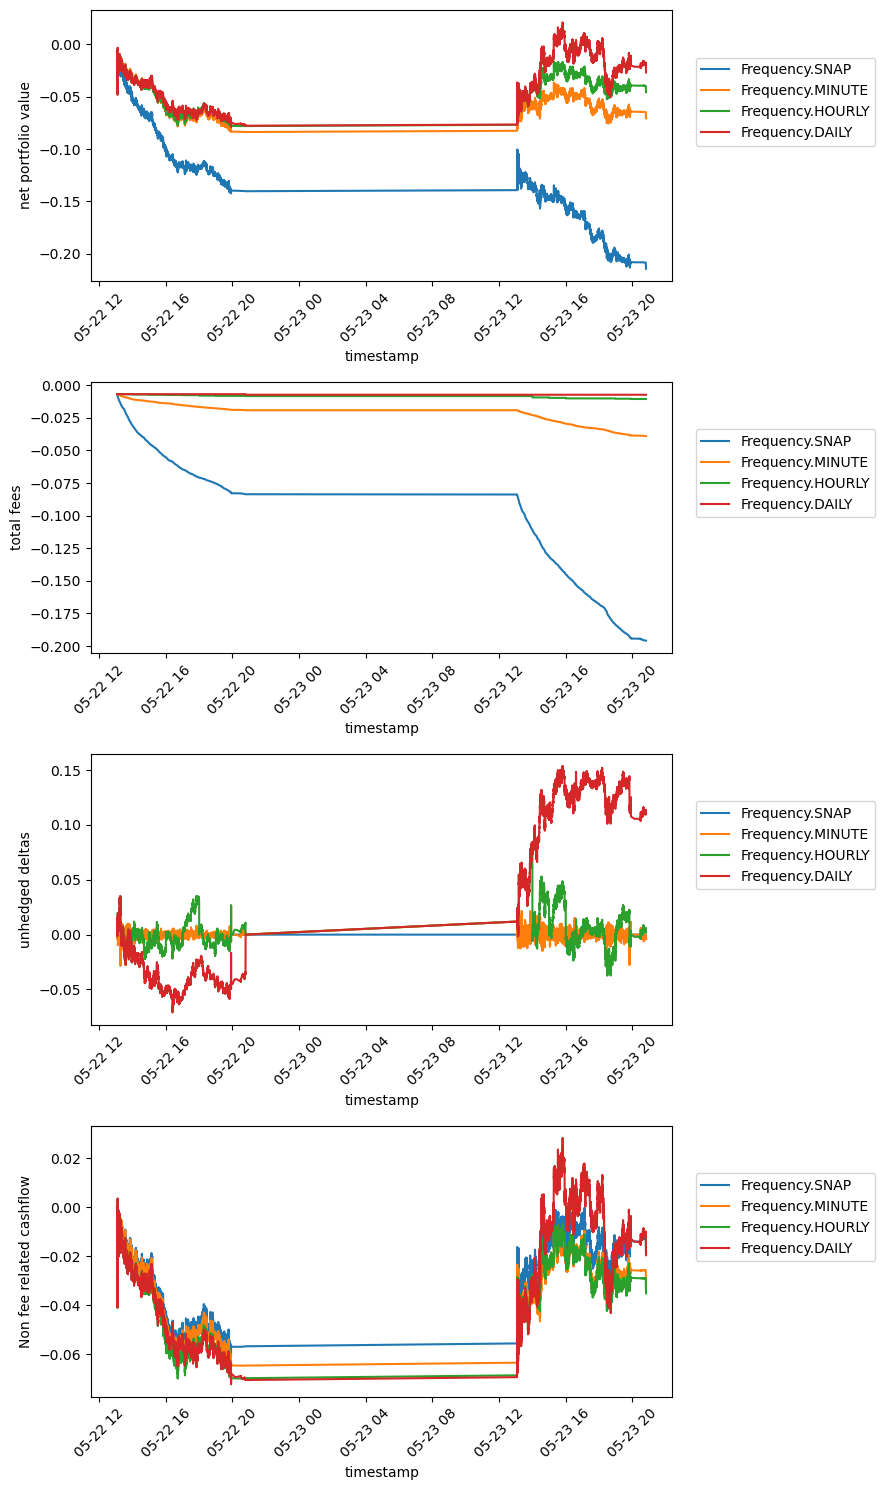

In [52]:
fig, axs = plt.subplots(4,1, figsize = (9,15))

for freq in frequencies:
    
    axs[0].plot(cls.data.index, cls.data[f'{freq}_freq_net_value'], label = freq)
    axs[0].set_ylabel('net portfolio value')
    
    axs[1].plot(cls.data.index, cls.data[f'{freq}_freq_tot_fees'], label = freq)
    axs[1].set_ylabel('total fees')
    
    axs[2].plot(cls.data.index, cls.data[f'{freq}_freq_exposure_arr'], label = freq)
    axs[2].set_ylabel('unhedged deltas')
    
    axs[3].plot(cls.data.index, cls.data[f'{freq}_freq_net_flow_exposure_arr'], label = freq)
    axs[3].set_ylabel('Non fee related cashflow')
    
for i in range(4):
    
    axs[i].tick_params(axis = 'x', rotation = 45)
    axs[i].set_xlabel('timestamp')
    axs[i].legend(loc = (1.04,0.5))

plt.tight_layout()
plt.show()

In [53]:
cls.data[(f'{freq}_freq_exposure_arr' for freq in frequencies)][:-1].describe().loc[['min','max']]

,Frequency.SNAP_freq_exposure_arr,Frequency.MINUTE_freq_exposure_arr,Frequency.HOURLY_freq_exposure_arr,Frequency.DAILY_freq_exposure_arr
min,0.0,-0.028455,-0.037331,-0.070930
max,0.0,0.025902,0.083492,0.153632


## 3.2 Fixed % Underlying Change

In [54]:
data = pd.read_csv('./grad_data_2023.csv')
cls = Hedger(data=data)

In [55]:
BPS = [5,10,20,50]

for bps in BPS:

    cls.under_change_calculate(under_change = bps)

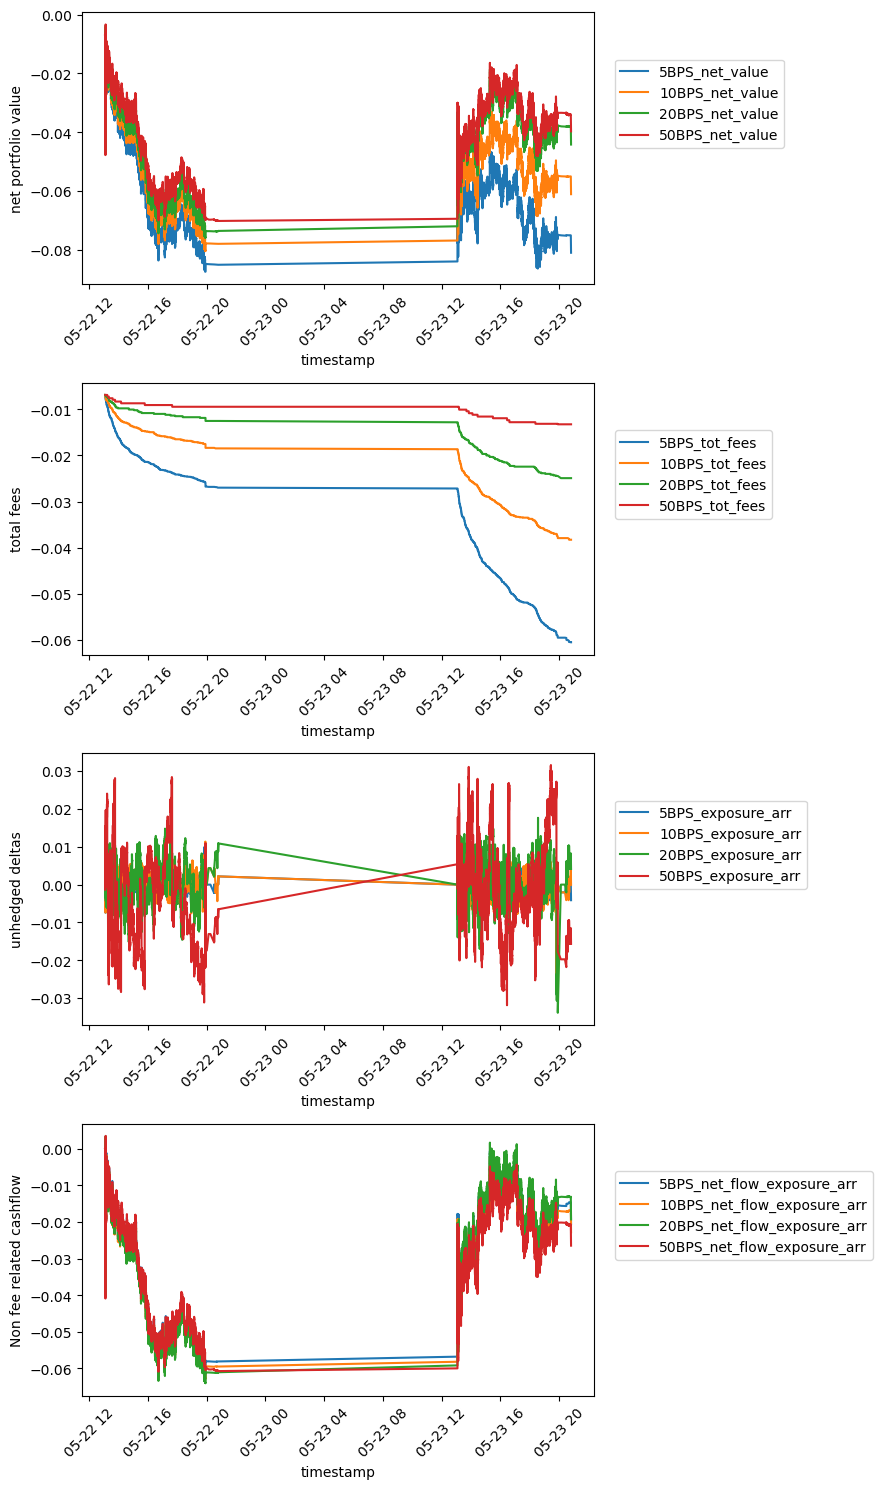

In [56]:
fig, axs = plt.subplots(4,1, figsize = (9,15))

for bps in BPS:
    
    axs[0].plot(cls.data.index, cls.data[f'{bps}BPS_net_value'], label = f'{bps}BPS_net_value')
    axs[0].set_ylabel('net portfolio value')
    
    axs[1].plot(cls.data.index, cls.data[f'{bps}BPS_tot_fees'], label = f'{bps}BPS_tot_fees')
    axs[1].set_ylabel('total fees')
    
    axs[2].plot(cls.data.index, cls.data[f'{bps}BPS_exposure_arr'], label = f'{bps}BPS_exposure_arr')
    axs[2].set_ylabel('unhedged deltas')
    
    axs[3].plot(cls.data.index, cls.data[f'{bps}BPS_net_flow_exposure_arr'], label = f'{bps}BPS_net_flow_exposure_arr')
    axs[3].set_ylabel('Non fee related cashflow')
    
for i in range(4):
    
    axs[i].tick_params(axis = 'x', rotation = 45)
    axs[i].set_xlabel('timestamp')
    axs[i].legend(loc = (1.04,0.5))

plt.tight_layout()
plt.show()

In [57]:
cls.data[(f'{bps}BPS_exposure_arr' for bps in BPS)][:-1].describe().loc[['min','max']]

,5BPS_exposure_arr,10BPS_exposure_arr,20BPS_exposure_arr,50BPS_exposure_arr
min,-0.028969,-0.028361,-0.033890,-0.031894
max,0.009898,0.011379,0.017672,0.031529


## 3.3 Fixed Delta Tolerance

In [58]:
data = pd.read_csv('./grad_data_2023.csv')
cls = Hedger(data=data)

In [59]:
delta_tol = [0.005, 0.01, 0.015, 0.02]

for tol in delta_tol:
    
    cls.delta_change_calculate(delta_change = tol)

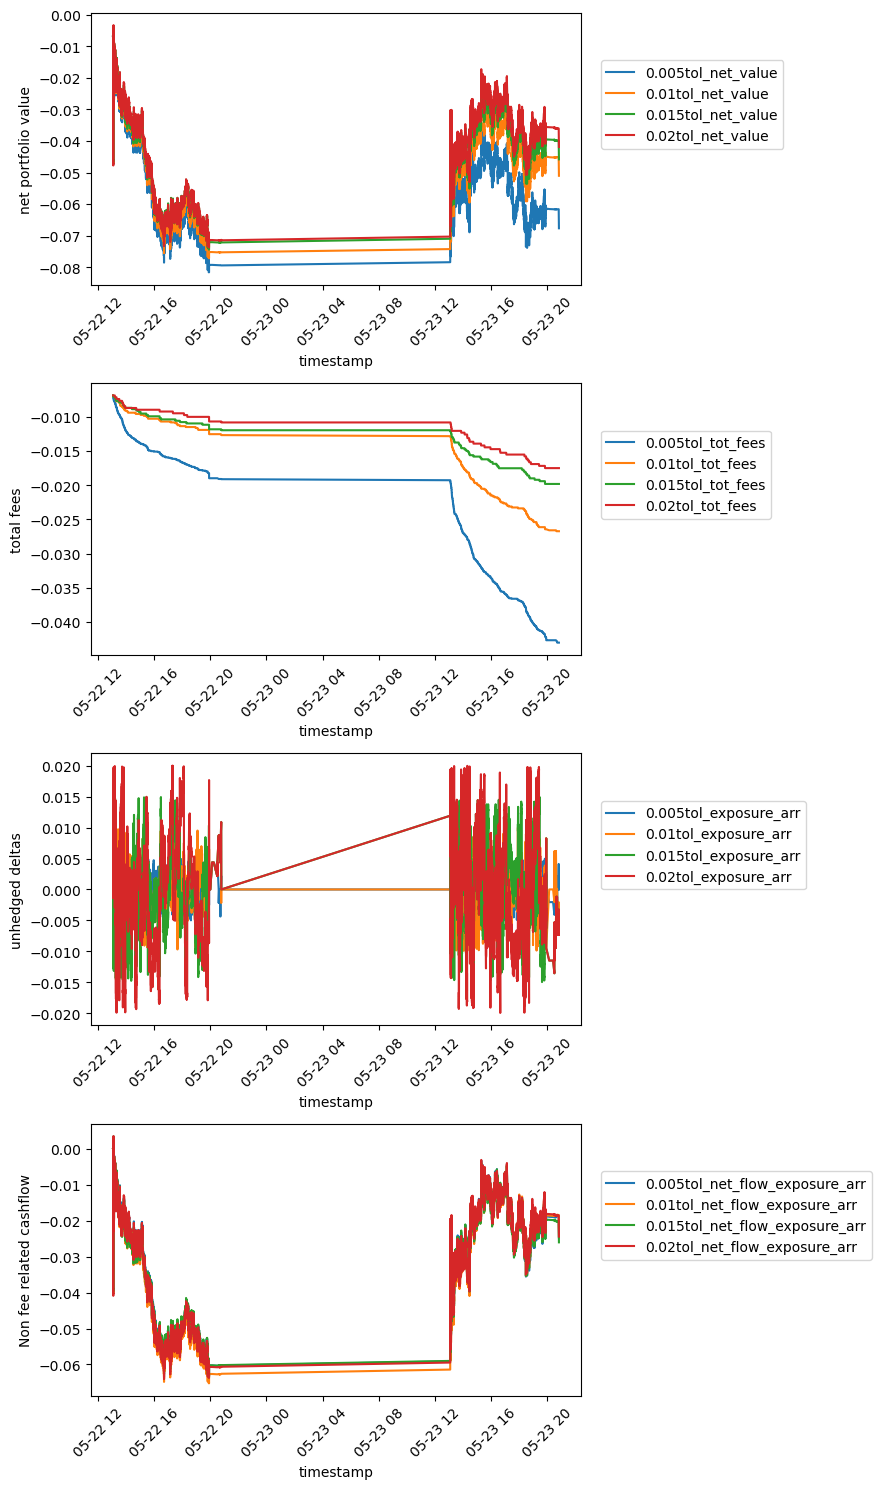

In [60]:
fig, axs = plt.subplots(4,1, figsize = (9,15))

for tol in delta_tol:
    
    axs[0].plot(cls.data.index, cls.data[f'{tol}tol_net_value'], label = f'{tol}tol_net_value')
    axs[0].set_ylabel('net portfolio value')
    
    axs[1].plot(cls.data.index, cls.data[f'{tol}tol_tot_fees'], label = f'{tol}tol_tot_fees')
    axs[1].set_ylabel('total fees')
    
    axs[2].plot(cls.data.index, cls.data[f'{tol}tol_exposure_arr'], label = f'{tol}tol_exposure_arr')
    axs[2].set_ylabel('unhedged deltas')
    
    axs[3].plot(cls.data.index, cls.data[f'{tol}tol_net_flow_exposure_arr'], label = f'{tol}tol_net_flow_exposure_arr')
    axs[3].set_ylabel('Non fee related cashflow')
    
for i in range(4):
    
    axs[i].tick_params(axis = 'x', rotation = 45)
    axs[i].set_xlabel('timestamp')
    axs[i].legend(loc = (1.04,0.5))

plt.tight_layout()
plt.show()

## 3.4 Fixed Delta Tolerance with Rolling Average Exposure

In [61]:
data = pd.read_csv('./grad_data_2023.csv')
cls = Hedger(data=data)

In [62]:
tol = 0.01
windows = [1,10,20,30,40]

for window in windows:

    cls.delta_average_hedge(window_size = window, tol = tol)

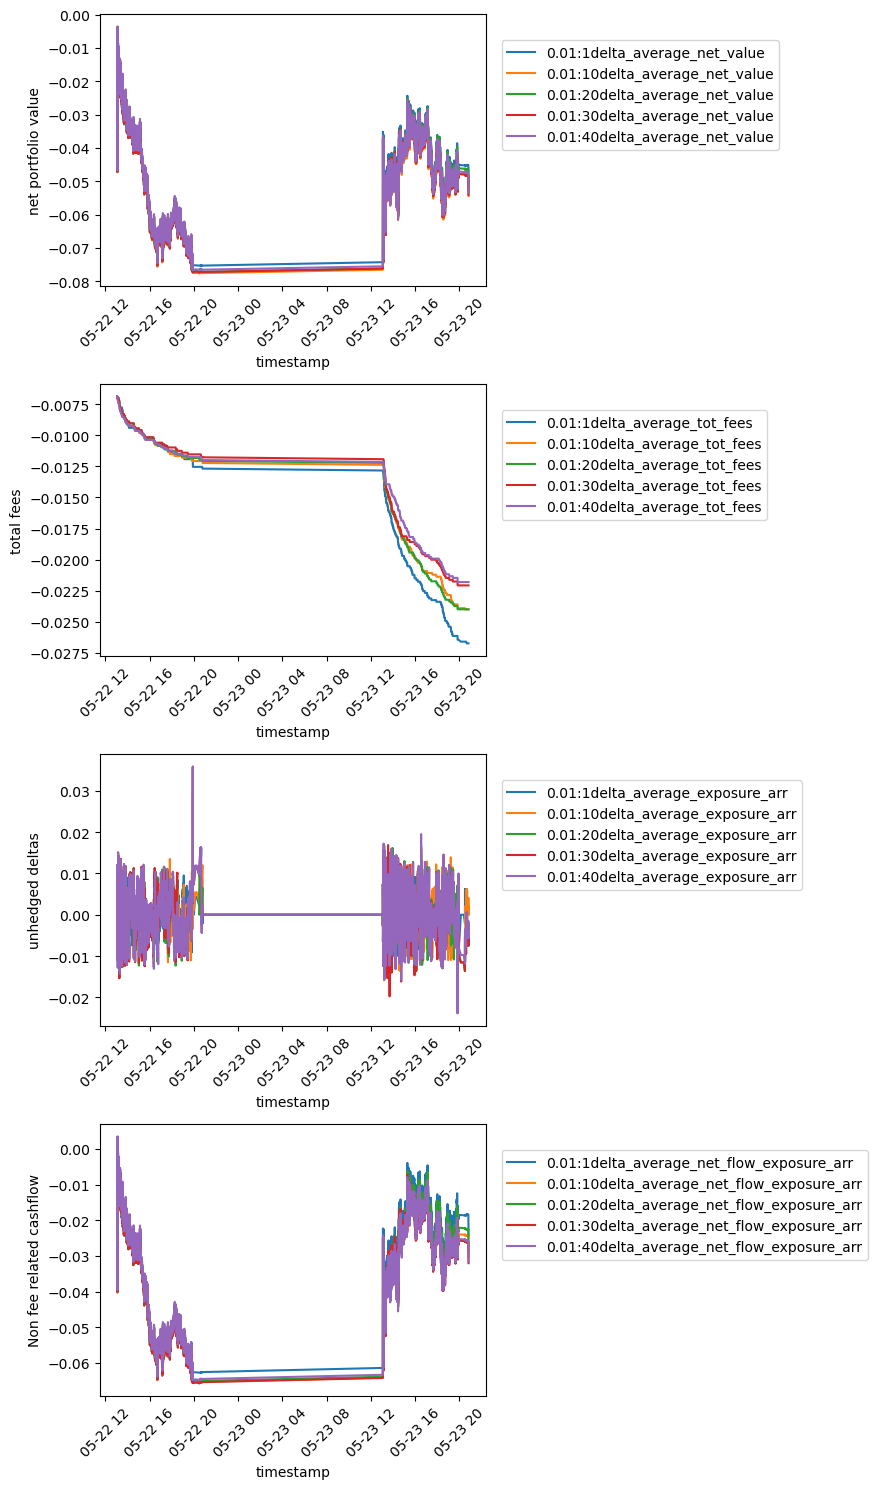

In [63]:
fig, axs = plt.subplots(4,1, figsize = (9,15))

for window in windows:
    
    axs[0].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_net_value'], label = f'{tol}:{window}delta_average_net_value')
    axs[0].set_ylabel('net portfolio value')
    
    axs[1].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_tot_fees'], label = f'{tol}:{window}delta_average_tot_fees')
    axs[1].set_ylabel('total fees')
    
    axs[2].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_exposure_arr'], label = f'{tol}:{window}delta_average_exposure_arr')
    axs[2].set_ylabel('unhedged deltas')
    
    axs[3].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_net_flow_exposure_arr'], label = f'{tol}:{window}delta_average_net_flow_exposure_arr')
    axs[3].set_ylabel('Non fee related cashflow')
    
for i in range(4):
    
    axs[i].tick_params(axis = 'x', rotation = 45)
    axs[i].set_xlabel('timestamp')
    axs[i].legend(loc = (1.04,0.5))

plt.tight_layout()
plt.show()

In [64]:
cls.data[(f'{tol}:{window}delta_average_exposure_arr' for window in windows)][:-1].describe().loc[['min','max']]

,0.01:1delta_average_exposure_arr,0.01:10delta_average_exposure_arr,0.01:20delta_average_exposure_arr,0.01:30delta_average_exposure_arr,0.01:40delta_average_exposure_arr
min,-0.009982,-0.023647,-0.020225,-0.023828,-0.023871
max,0.009996,0.029476,0.035708,0.035826,0.035932


## 3.5 Summary

All of these strategies produce very similar net value portfolio graphs, however some of them have undesirable features.

It seems hedging at discrete times doesnt provide much protection from risk as its very possible a big sudden move will have you in a riskier position than you would like. 

The underlying % change and fixed delta tolerance are very similar strategies. Since gamma is small and the underlying doesnt change drastically delta is close to linear in the underlying. However in this data our option is ATM. If it was deep ITM or OTM, a large change in price might not change delta much depending on the direction, in this case the underlying % change strategy would lead to us hedging and incurring transaction fees when it is not necessary so for this reason we prefer the fixed delta tolerance strategy.

The idea behind adding a moving window to this strategy is that if the price suddenly changes but reverts relatively quickly we dont want to have to hedge twice and incur fees and potential losses due to exposure. The drawback however is we are slower to react to market movements and will potentially take on more exposure than if we had not used a window as we can see above. However these events are rare and soon hedged so we dont take on too much necessary exposure. Later on we will define a metric and see that, according to that metric, it is preferable to use a window.

# 4 Exploratory Data Analysis and Optimal Delta Hedges

## 4.1 Data Preparation

In [65]:
def prepare_data(df, open_time, close_time, date = None):

    # transforms data into the appropriate form to work with (dont need to change)
    df = df.copy()
    df.set_index('theo_event_tx_timestamp',inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    df = df.between_time(open_time, close_time)
    
    if date == '2023-05-22':
            
        df = df.loc['2023-05-22']
        
    elif date == '2023-05-23':
            
        df = df.loc['2023-05-23']
            
    df['id'] = range(df.shape[0])

    return df

In [66]:
data = pd.read_csv('./grad_data_2023.csv')
data_day1 = prepare_data(data, '13:05', '20:50', '2023-05-22')
data_day2 = prepare_data(data, '13:05', '20:50', '2023-05-23')

In [67]:
cls_day1 = Hedger(data=data, date = '2023-05-22')
cls_day2 = Hedger(data=data, date = '2023-05-23')

cls_day1.time_based_calculate(Frequency.SNAP)
cls_day2.time_based_calculate(Frequency.SNAP)

## 4.2 A correlation between the underlying and non-fee related cash flow

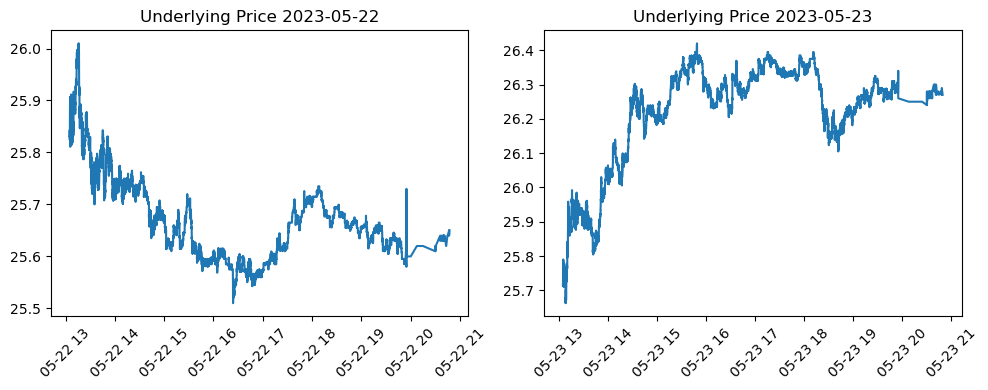

In [68]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

axs[0].plot(data_day1.index, data_day1['under'])
axs[0].tick_params(axis = 'x', rotation = 45)
axs[0].set_title('Underlying Price 2023-05-22')

axs[1].plot(data_day2.index, data_day2['under'])
axs[1].tick_params(axis = 'x', rotation = 45)
axs[1].set_title('Underlying Price 2023-05-23')

plt.tight_layout()
plt.show()

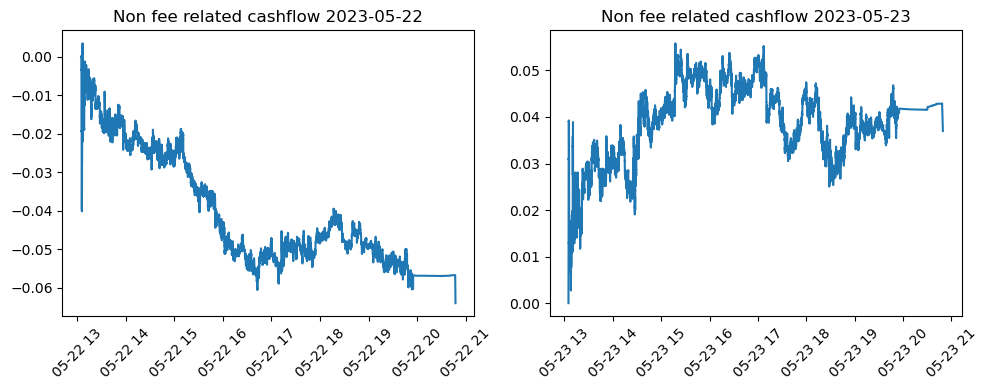

In [69]:
fig, axs = plt.subplots(1, 2, figsize = (10,4))

axs[0].plot(cls_day1.data.index,
            cls_day1.data[f'{Frequency.SNAP}_freq_net_flow_exposure_arr'])
axs[0].tick_params(axis = 'x', rotation = 45)
axs[0].set_title('Non fee related cashflow 2023-05-22')

axs[1].plot(cls_day2.data.index,
            cls_day2.data[f'{Frequency.SNAP}_freq_net_flow_exposure_arr'])
axs[1].tick_params(axis = 'x', rotation = 45)
axs[1].set_title('Non fee related cashflow 2023-05-23')

plt.tight_layout()
plt.show()

In [70]:
cls_day1.data[['under',f'{Frequency.SNAP}_freq_net_flow_exposure_arr']].corr()

,under,Frequency.SNAP_freq_net_flow_exposure_arr
under,1.000000,0.770628
Frequency.SNAP_freq_net_flow_exposure_arr,0.770628,1.000000


In [71]:
cls_day2.data[['under',f'{Frequency.SNAP}_freq_net_flow_exposure_arr']].corr()

,under,Frequency.SNAP_freq_net_flow_exposure_arr
under,1.000000,0.797358
Frequency.SNAP_freq_net_flow_exposure_arr,0.797358,1.000000


We see there is a consistent positive correlation between the price of the underlying and our non fee related cash flow, even when we hedge at every instant. This can be explained if our portfolio is a proxy for being long some amount of the underlying and so we are overhedged. Assuming the theoretical values are obtained via Black Scholes model then this could be explained by the constant volatility assumption. Below we explore some alternative deltas.

## 4.3 Optimal Delta Hedges

In [72]:
data = pd.read_csv('./grad_data_2023.csv')
data = prepare_data(data, '13:05', '20:50')

### 4.3.1 Hedging with Table Given Delta

In [73]:
tv_diff = np.array(data['tv'].diff().shift(-1).dropna())
under_diff = np.array(data['under'].diff().shift(-1).dropna())
delta = np.array(data['delta'][:-1])

In [74]:
R = np.corrcoef(tv_diff, np.multiply(delta,under_diff))[0,1]
print(f'Coefficient of determination: {R**2}')

Coefficient of determination: 0.959888924851794


### 4.3.2 Black Scholes Delta

Black Scholes Delta:

$$
\frac{\partial P}{\partial S} = \delta_{BS}
$$

try regression of the form

$$
\Delta P = \beta_0 + \beta_1 \delta_{BS} \Delta S + \epsilon
$$

In [75]:
tv_diff = np.array(data['tv'].diff().shift(-1).dropna())
under_diff = np.array(data['under'].diff().shift(-1).dropna())
delta = np.array(data['delta'][:-1])

In [76]:
X_BS = np.multiply(delta,under_diff).reshape(-1,1)
y_BS = tv_diff

In [77]:
reg_BS = LinearRegression().fit(X_BS,y_BS)
print(f'Coefficient of determination: {reg_BS.score(X_BS, y_BS) }')

Coefficient of determination: 0.9598889248517931


In [78]:
# the multiplier of the amount of delta we should hedge

reg_BS.coef_

array([0.99914593])

In [79]:
# gives us an approximate value for time decay from row to row

reg_BS.intercept_

-1.1273354514857151e-07

### 4.3.3 Smile Adjusted Delta

In reality $\sigma$ is not constant and changes with the underlying, this in turn changes option price. Smile adjusted delta (or local volatility minimum variance delta) addresses this.

$$
\delta_{SAD} = \frac{dP}{dS} = \frac{\partial P}{\partial S} + \frac{\partial P}{\partial \sigma}
                                                                \frac{\partial \sigma}{\partial S}
$$

$$
\implies \delta_{SAD} = \delta_{BS} + \nu_{BS} \frac{\partial \sigma}{\partial S}
$$

Which can be approximated as

$$
\delta_{SAD} = \delta_{BS} + \nu_{BS} \frac{\partial \sigma}{\partial K}
$$

Since the volatility smile of index options tends to be approximately linear (see e.g., Rubinstein, 1994; Derman, 1999)

After discretising we can then try a regression of the form

$$
\Delta P = \beta_0 + \beta_1 \delta_{BS}\Delta S + \beta_2 \nu_{BS} \Delta S + \epsilon
$$

In [80]:
tv_diff = np.array(data['tv'].diff().shift(-1).dropna())
under_diff = np.array(data['under'].diff().shift(-1).dropna())
delta = np.array(data['delta'][:-1])
vega = np.array(data['vega'][:-1])

In [81]:
x1 = np.multiply(delta, under_diff).reshape(-1,1)
x2 = np.multiply(vega, under_diff).reshape(-1,1)
X_SAD = np.concatenate((x1, x2), axis = 1)
y_SAD = tv_diff 

In [82]:
reg_SAD = LinearRegression().fit(X_SAD, y_SAD)
print(f'Coefficient of determination: {reg_SAD.score(X_SAD, y_SAD) }')

Coefficient of determination: 0.9598893993426872


In [83]:
reg_SAD.coef_

array([ 0.99255866, -0.00123345])

In [84]:
reg_SAD.intercept_

-1.1478900142183719e-07

### 4.3.4 Hull and White Minimum Variance Delta

Hull and White show the minimum variance delta is approximately quadratic in the black scholes delta and propose a linear regression model:

$$
\delta_{MV} = \beta_0 + \beta_1 \delta_{BS} + \frac{\nu_{BS}}{S\sqrt T}(\beta_2 + \beta_3\delta_{BS} + \beta_4\delta_{BS}^2)
$$

In [85]:
tv_diff = np.array(data['tv'].diff().shift(-1).dropna())
under_diff = np.array(data['under'].diff().shift(-1).dropna())
under = np.array(data['under'][1:])
tte = np.array(data['tte'][:-1])
delta = np.array(data['delta'][:-1])
vega = np.array(data['vega'][:-1])

VST = np.divide(vega, np.multiply(under, np.sqrt(tte)))

In [86]:
x1 = np.multiply(delta, under_diff).reshape(-1,1)
x2 = VST.reshape(-1,1)
x3 = np.multiply(VST, delta).reshape(-1,1)
x4 = np.multiply(VST, delta**2).reshape(-1,1)
X_HW = np.concatenate((x1,x2,x3,x4), axis = 1)
y_HW = tv_diff

In [87]:
reg_HW = LinearRegression().fit(X_HW, y_HW)
print(f'Coefficient of determination: {reg_HW.score(X_HW, y_HW)}')

Coefficient of determination: 0.9598900469612723


In [88]:
reg_HW.coef_ 

array([0.99910058, 0.00231026, 0.00342192, 0.00336664])

In [89]:
reg_HW.intercept_

-0.000573915102899642

### 4.3.5 SLA Delta

Minimum variance hedge ratio obtained from the short-lived arbitrage model is given by (see Hilliard & Ni, 2021): 

$$
\delta_{MV} = \frac{\partial P}{\partial S} + c_1S\frac{\partial^2 P}{\partial S^2} + c_2\frac{\partial P}{\partial \sigma}
$$

so we try a regression model of the form

$$
\Delta P = \beta_0 + \beta_1 \delta_{BS}\Delta S + \beta_2 \Gamma_{BS} S\Delta S + \beta_3 \nu_{BS} \Delta S + \epsilon
$$

In [90]:
tv_diff = np.array(data['tv'].diff().shift(-1).dropna())
under_diff = np.array(data['under'].diff().shift(-1).dropna())
under = np.array(data['under'][1:])
delta = np.array(data['delta'][:-1])
vega = np.array(data['vega'][:-1])
gamma = np.array(data['gamma'][:-1])

In [91]:
x1 = np.multiply(delta, under_diff).reshape(-1,1)
x2 = np.multiply(np.multiply(gamma, under), under_diff).reshape(-1,1)
x3 = np.multiply(vega, under_diff).reshape(-1,1)
X_SLA = np.concatenate((x1, x2, x3), axis = 1)
y_SLA = tv_diff

In [92]:
reg_SLA = LinearRegression().fit(X_SLA, y_SLA)
print(f'Coefficient of determination: {reg_SLA.score(X_SLA, y_SLA)}')

Coefficient of determination: 0.9598949999497162


In [93]:
reg_SLA.coef_

array([ 0.99177774,  0.00398983, -0.00925694])

In [94]:
reg_SLA.intercept_

-1.2270440731145328e-07

### 4.3.6 Summary

Whilst these alternative deltas produce slightly different methods of hedging with SLA minimum variance having the best value of R^2, the difference in values of R^2 across all deltas is insignificant, and no given delta explains the positive correlation of the underlying asset and our non fee related cash flow. So moving forward we will just be hedging as standard with the delta given in the table.

### 4.3.7 References

Derman, E. (1999). Regimes of volatility. Risk 12:4, 55-59.

Hilliard, J. and Ni, Y. (2021). Using the short-lived arbitrage model to compute minimum variance hedge ratios: application to indices, stocks and commodities. Quant. Finance, 21 (1) (2021), pp. 125-142

Hull, J. and White, A. (2017). Optimal Delta Hedging for Options. Journal of Banking and Finance, Vol. 82, 180-190.

Rubinstein, M. (1994). Implied binomial trees. Journal of Finance 69, 771-818.

# 5 Metrics to Measure a Strategies Performance

As noted above, delta hedging with the table values seems to give us a positive exposure to the underlying. If we were to define a metric which measures net portfolio value it may favour hedging strategies with larger exposures. This would not generalise well because if we were given data with a downward trend we would have a larger negative cash flow.

We will be using a metric which combines the RMSHE (root mean squared hedging error) and our incurred fees. We first define a function to find these quantities for a range of parameter values and calculate the means. We will then normalise the RMSHE and incurred fees and them sum them (efectively given them equal weighting). We then aim to minimise this function.

The problem with normalising is that the means will be different for different ranges of tolerance and window size used. So instead of comparing absolute scores across different strategies (fixed tolerance vs fixed tolerance with rolling average) we will instead compare the correlation between the metric scores on day 1 and day 2 of this data. A higher correlation should imply a more readily generalisable optimisation process for the strategy.

## 5.1 Functions

In [95]:
# call this first to obtain normalisation values, only needs to be run once

def RMSHE_normalisation_constants(tol_arr, window_arr, data = pd.read_csv('./grad_data_2023.csv'), date = None):
     
    # arr is an array containing the delta tolerances we want to use to estimate the mean
    
    cls = Hedger(data=data, date=date)
    
    RMSHE = []
    tot_fees = []
    
    for delta_tol in tol_arr:
        
        for window in window_arr:

            cls.delta_average_hedge(tol = delta_tol, window_size = window)

            arr = cls.data[f'{delta_tol}:{window}delta_average_exposure_arr']
            RMSHE.append(np.sqrt(np.mean(arr**2)))

            tot_fees.append(cls.data[f'{delta_tol}:{window}delta_average_tot_fees'].iloc[-1])
        
    RMSHE = np.array(RMSHE)
    tot_fees = np.array(np.abs(tot_fees))
    
    return [RMSHE.mean(), tot_fees.mean()]

In [96]:
# calculates a 'normalised' RMSHE + fees metric

def RMSHE_metric_fn(delta_tol,
                    window_size,
                    RMSHE_mean,
                    tot_fees_mean,
                    data = pd.read_csv('./grad_data_2023.csv'),
                    date = None):
    
    cls = Hedger(data=data, date=date)
    cls.delta_average_hedge(tol = delta_tol, window_size = window_size)
    arr = cls.data[f'{delta_tol}:{window_size}delta_average_exposure_arr']
    RMSHE = np.sqrt(np.mean(arr**2))
    tot_fees = np.abs(cls.data[f'{delta_tol}:{window_size}delta_average_tot_fees'].iloc[-1])
    
    return RMSHE/RMSHE_mean + tot_fees/tot_fees_mean

## 5.2 Fixed Delta Tolerance (No Rolling Window)

### 5.2.1 Plotting the Metric for a Range of Delta Tolerances

In [97]:
# calling normalisation function to estimate mean for RMSHE and total fees, only needs to be called once

tol_arr = np.linspace(0,0.05,40)
window_arr = [1]
constants = RMSHE_normalisation_constants(tol_arr, window_arr)
RMSHE_mean = constants[0]
tot_fees_mean = constants[1]

/tmp/ipykernel_39738/716771202.py:289: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data[f'{tol}:{window_size}delta_average_net_value'] = net_value_arr
/tmp/ipykernel_39738/716771202.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data[f'{tol}:{window_size}delta_average_tot_fees'] = total_fees_arr
/tmp/ipykernel_39738/716771202.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [98]:
# calculating RMSHE_metric using the means we found in previous cells

tol_arr = np.linspace(0,0.05,40)
window_arr = [1]
RMSHE_metric = []

for delta_tol in tol_arr:
    for window in window_arr:
    
        RMSHE_metric.append(RMSHE_metric_fn(delta_tol, window, RMSHE_mean, tot_fees_mean))
    
RMSHE_metric = np.array(RMSHE_metric)

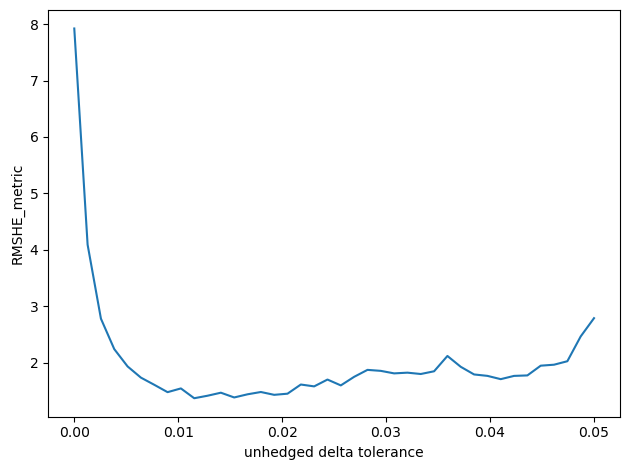

In [99]:
fig, ax = plt.subplots()

ax.plot(tol_arr, RMSHE_metric)
ax.set_xlabel('unhedged delta tolerance')
ax.set_ylabel('RMSHE_metric')

plt.tight_layout()
plt.show()

### 5.2.2 Optimising

We will use the hyperopt library to minimise my risk metric as scipy often gets stuck on local minima

In [100]:
space = {'delta_tol' : hp.uniform('delta_tol', 0.005, 0.025),
         'window_size' : 1,
         'RMSHE_mean' : RMSHE_mean,
         'tot_fees_mean' : tot_fees_mean}

NameError: name 'hp' is not defined

In [105]:
def objective(space):
    
    return {'loss' : RMSHE_metric_fn(space['delta_tol'],
                                     int(space['window_size']),
                                     RMSHE_mean = space['RMSHE_mean'],
                                     tot_fees_mean = space['tot_fees_mean'],
                                     data = pd.read_csv('./grad_data_2023.csv'),
                                     date = None),
            'status': STATUS_OK}

In [106]:
trials = Trials()

RMSHE_best = fmin(fn=objective,
               space=space,
               algo=tpe.suggest,
               trials = trials,
               max_evals=100)
print(RMSHE_best)  

100%|████████| 100/100 [06:54<00:00,  4.14s/trial, best loss: 1.321340456313871]
{'delta_tol': 0.011957519486745855}


### 5.2.3 Correlation of the RMSHE Metric Across Days

In [107]:
tol_arr = np.linspace(0,0.05,40)
window_arr = [1]

data = pd.read_csv('./grad_data_2023.csv')
day1_RMSHE_loss = []
day2_RMSHE_loss = []

In [108]:
day1_constants = RMSHE_normalisation_constants(tol_arr, window_arr, date = '2023-05-22')

day1_RMSHE_mean = day1_constants[0]
day1_tot_fees_mean = day1_constants[1]

day2_constants = RMSHE_normalisation_constants(tol_arr, window_arr, date = '2023-05-23')

day2_RMSHE_mean = day2_constants[0]
day2_tot_fees_mean = day2_constants[1]

In [109]:
for tol in tol_arr:
    
    for window in window_arr:
    
        day1_RMSHE_loss.append(RMSHE_metric_fn(tol,
                                               window,
                                               RMSHE_mean = day1_RMSHE_mean,
                                               tot_fees_mean = day1_tot_fees_mean,
                                               date = '2023-05-22'))

        day2_RMSHE_loss.append(RMSHE_metric_fn(tol,
                                               window,
                                               RMSHE_mean = day2_RMSHE_mean,
                                               tot_fees_mean = day2_tot_fees_mean,
                                               date = '2023-05-23'))
    
day1_RMSHE_loss = np.array(day1_RMSHE_loss)
day2_RMSHE_loss = np.array(day2_RMSHE_loss)

<IPython.core.display.Javascript object>


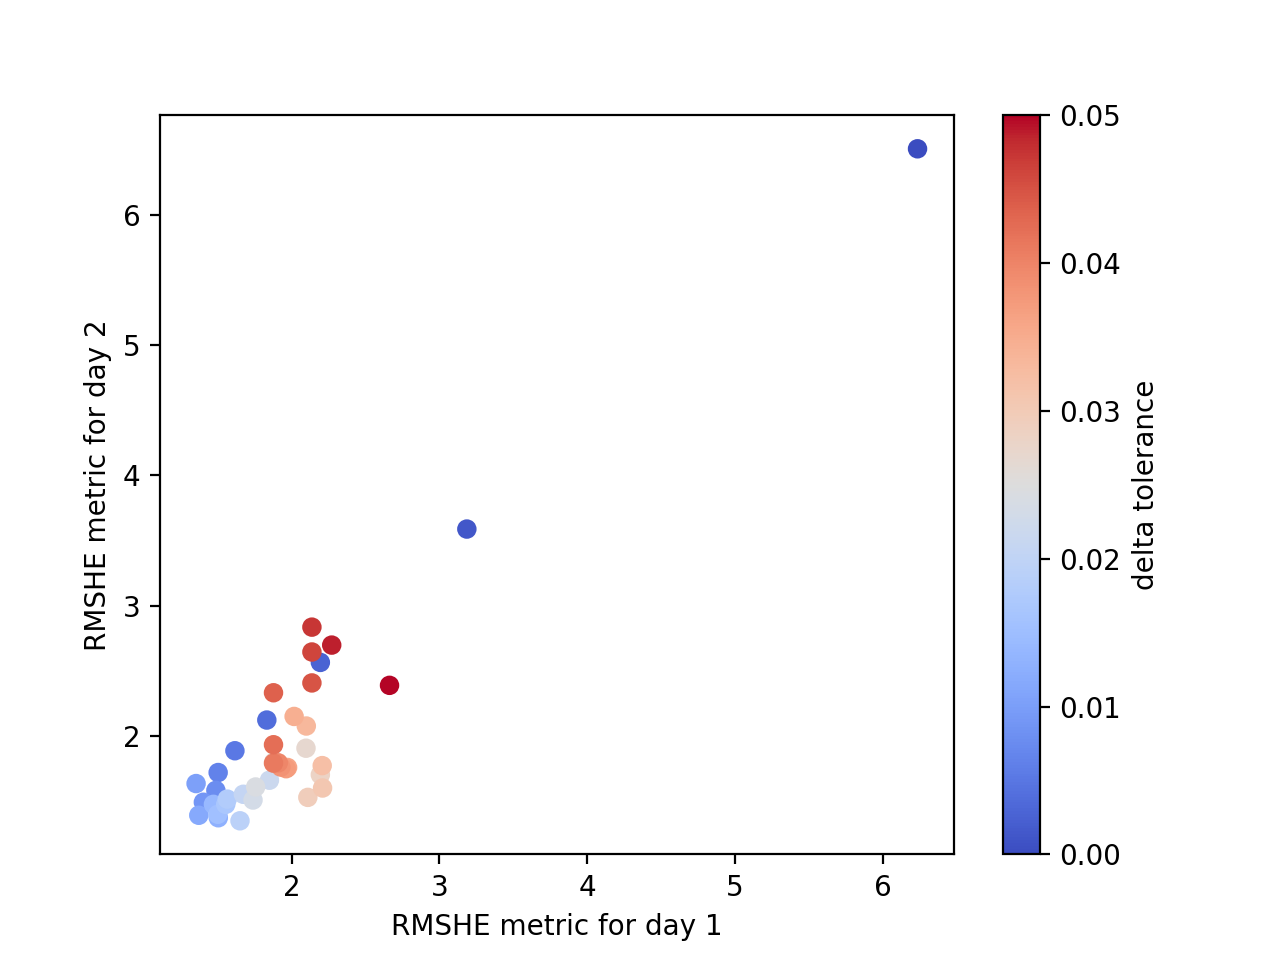

In [110]:
fig, ax = plt.subplots()

plot = ax.scatter(day1_RMSHE_loss, day2_RMSHE_loss, c = tol_arr, cmap = plt.cm.coolwarm)
ax.set_xlabel('RMSHE metric for day 1')
ax.set_ylabel('RMSHE metric for day 2')

fig.colorbar(plot, label = 'delta tolerance')

In [111]:
np.corrcoef(day1_RMSHE_loss, day2_RMSHE_loss)

array([[1.        , 0.93980494],
       [0.93980494, 1.        ]])

## 5.3 Fixed Delta Tolerance (Rolling Window)

### 5.3.1 Plotting Metric for a Range of Delta Tolerances and Window Sizes

In [154]:
tol_arr = np.linspace(0,0.05,10)
window_arr = np.arange(1,41,4)
constants = RMSHE_normalisation_constants(tol_arr, window_arr)
RMSHE_mean = constants[0]
tot_fees_mean = constants[1]

In [155]:
tol_arr = np.linspace(0,0.05,10)
window_arr = np.arange(1,41,4)
RMSHE_metric = []

for delta_tol in tol_arr:
    for window in window_arr:
    
        RMSHE_metric.append(RMSHE_metric_fn(delta_tol, window, RMSHE_mean, tot_fees_mean))
    
RMSHE_metric = np.array(RMSHE_metric)

In [156]:
window_arr, tol_arr = np.meshgrid(window_arr, tol_arr)
z = RMSHE_metric.reshape(10,10)

<IPython.core.display.Javascript object>


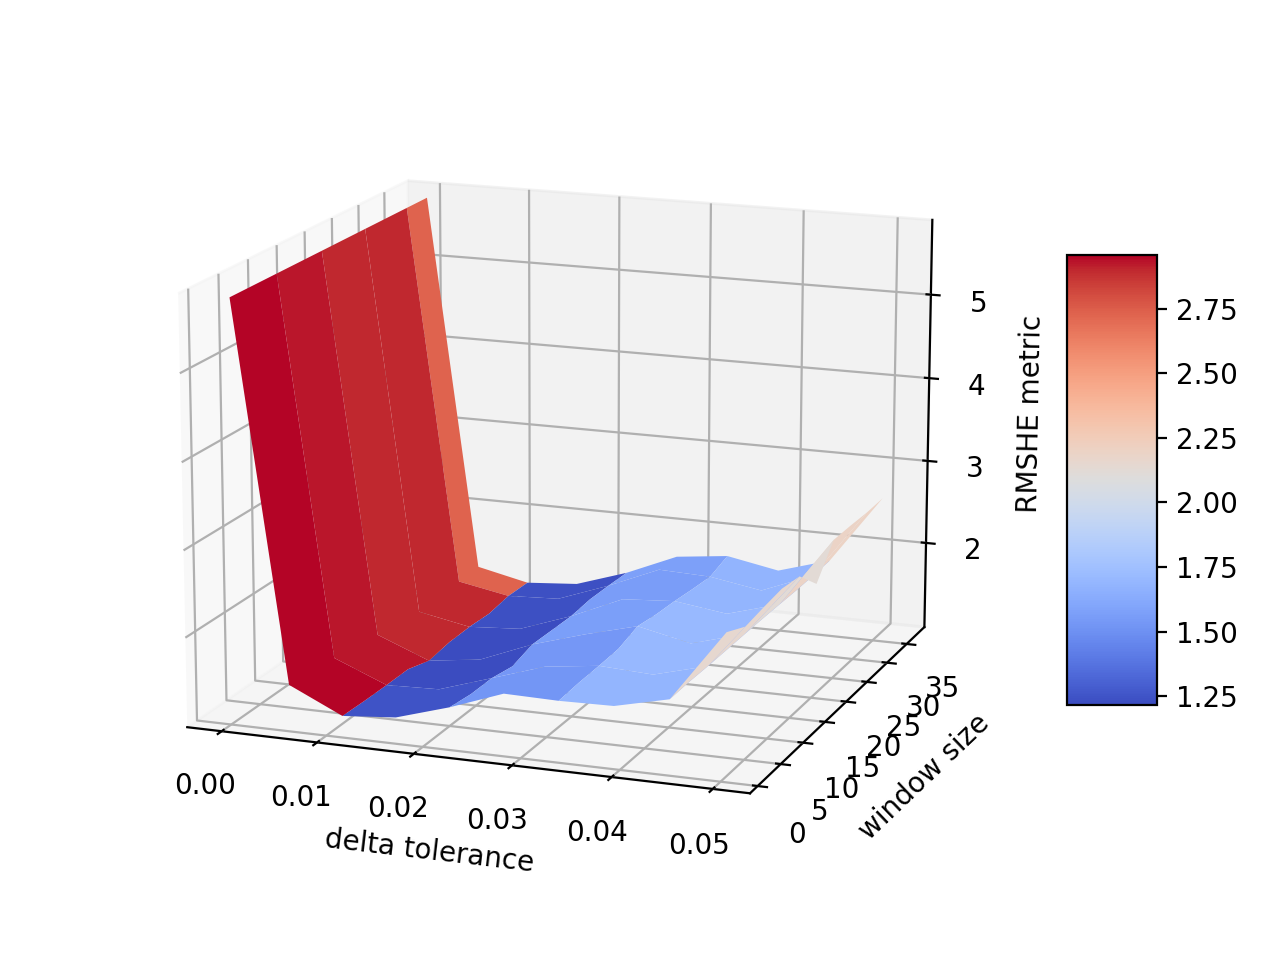

In [157]:
fig = plt.figure()

ax = plt.axes(projection = '3d')  

surf = ax.plot_surface(tol_arr, window_arr, z,
                       rstride=2,
                       cstride=2,
                       cmap=plt.cm.coolwarm,
                       linewidth=0.5,
                       antialiased=True)

ax.set_xlabel('delta tolerance')  

ax.set_ylabel('window size')

ax.set_zlabel('RMSHE metric')

fig.colorbar(surf, shrink=0.5, aspect=5)  

plt.tight_layout()

### 5.3.2 Optimising

In [183]:
space = {'delta_tol' : hp.uniform('delta_tol', 0.005, 0.025),
         'window_size' : hp.quniform('window_size', 1, 30,1),
         'RMSHE_mean' : RMSHE_mean,
         'tot_fees_mean' : tot_fees_mean}

In [184]:
def objective(space):
    
    return {'loss' : RMSHE_metric_fn(space['delta_tol'],
                                     int(space['window_size']),
                                     RMSHE_mean = space['RMSHE_mean'],
                                     tot_fees_mean = space['tot_fees_mean'],
                                     data = pd.read_csv('./grad_data_2023.csv'),
                                     date = None),
            'status': STATUS_OK}

In [185]:
trials = Trials()

RMSHE_best = fmin(fn=objective,
               space=space,
               algo=tpe.suggest,
               trials = trials,
               max_evals=100)
print(RMSHE_best)  

100%|███████| 100/100 [07:07<00:00,  4.27s/trial, best loss: 1.0448124656350808]
{'delta_tol': 0.01191355377996924, 'window_size': 18.0}


### 5.3.3 Correlation of the RMSHE Metric Across Days

In [161]:
tol_arr = np.linspace(0,0.05,10)
window_arr = np.arange(1,41,4)

data = pd.read_csv('./grad_data_2023.csv')
day1_RMSHE_loss = []
day2_RMSHE_loss = []

In [162]:
day1_constants = RMSHE_normalisation_constants(tol_arr, window_arr, date = '2023-05-22')

day1_RMSHE_mean = day1_constants[0]
day1_tot_fees_mean = day1_constants[1]

day2_constants = RMSHE_normalisation_constants(tol_arr, window_arr, date = '2023-05-23')

day2_RMSHE_mean = day2_constants[0]
day2_tot_fees_mean = day2_constants[1]

In [163]:
for tol in tol_arr:
    
    for window in window_arr:
    
        day1_RMSHE_loss.append(RMSHE_metric_fn(tol,
                                               window,
                                               RMSHE_mean = day1_RMSHE_mean,
                                               tot_fees_mean = day1_tot_fees_mean,
                                               date = '2023-05-22'))

        day2_RMSHE_loss.append(RMSHE_metric_fn(tol,
                                               window,
                                               RMSHE_mean = day2_RMSHE_mean,
                                               tot_fees_mean = day2_tot_fees_mean,
                                               date = '2023-05-23'))
    
day1_RMSHE_loss = np.array(day1_RMSHE_loss)
day2_RMSHE_loss = np.array(day2_RMSHE_loss)

<IPython.core.display.Javascript object>


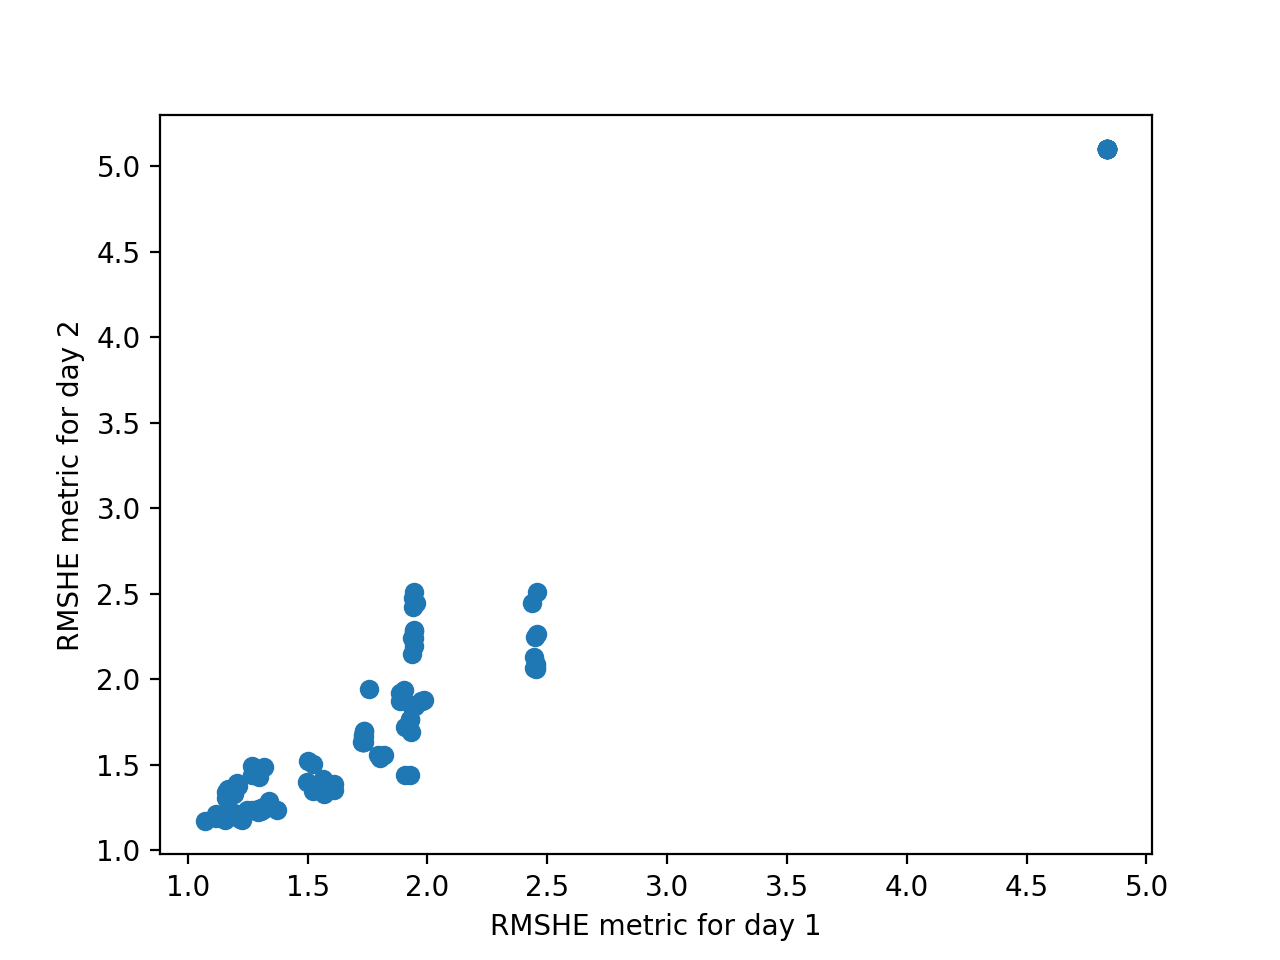

Text(0, 0.5, 'RMSHE metric for day 2')

In [164]:
fig, ax = plt.subplots()

plot = ax.scatter(day1_RMSHE_loss, day2_RMSHE_loss)
ax.set_xlabel('RMSHE metric for day 1')
ax.set_ylabel('RMSHE metric for day 2')

In [165]:
np.corrcoef(day1_RMSHE_loss, day2_RMSHE_loss)

array([[1.        , 0.98101309],
       [0.98101309, 1.        ]])

## 5.4 Summary

As we can see the RMSHE metric has a better correlation across both days with windows included and so using windows better generalises the outcome to unseen data. Furthermore we can see that the no windows approach is equivalent to having window size of 1, however the minimal loss was provided for a higher window size of 27.

# 6 Final Model

We have decided to use the fixed delta tolerance with our exposure being calculated with a rolling window. In addition to this we hedge at the end of every day regardless of our exposure, the idea behind this is that some trading occurs in out of market hours, the price of the underlying fluctuates as does the delta and we are unable to hedge ourselves against these changes, therefore hedging at the end of the day reduces our exposure to such events.

Here we compare it to a fixed delta strategy with the same tolerance but no rolling window.

In [186]:
data = pd.read_csv('./grad_data_2023.csv')
cls = Hedger(data=data)

In [187]:
tol = RMSHE_best['delta_tol']
window = int(RMSHE_best['window_size'])

cls.delta_average_hedge(window_size = window, tol = tol)
cls.delta_change_calculate(delta_change = tol)

<IPython.core.display.Javascript object>


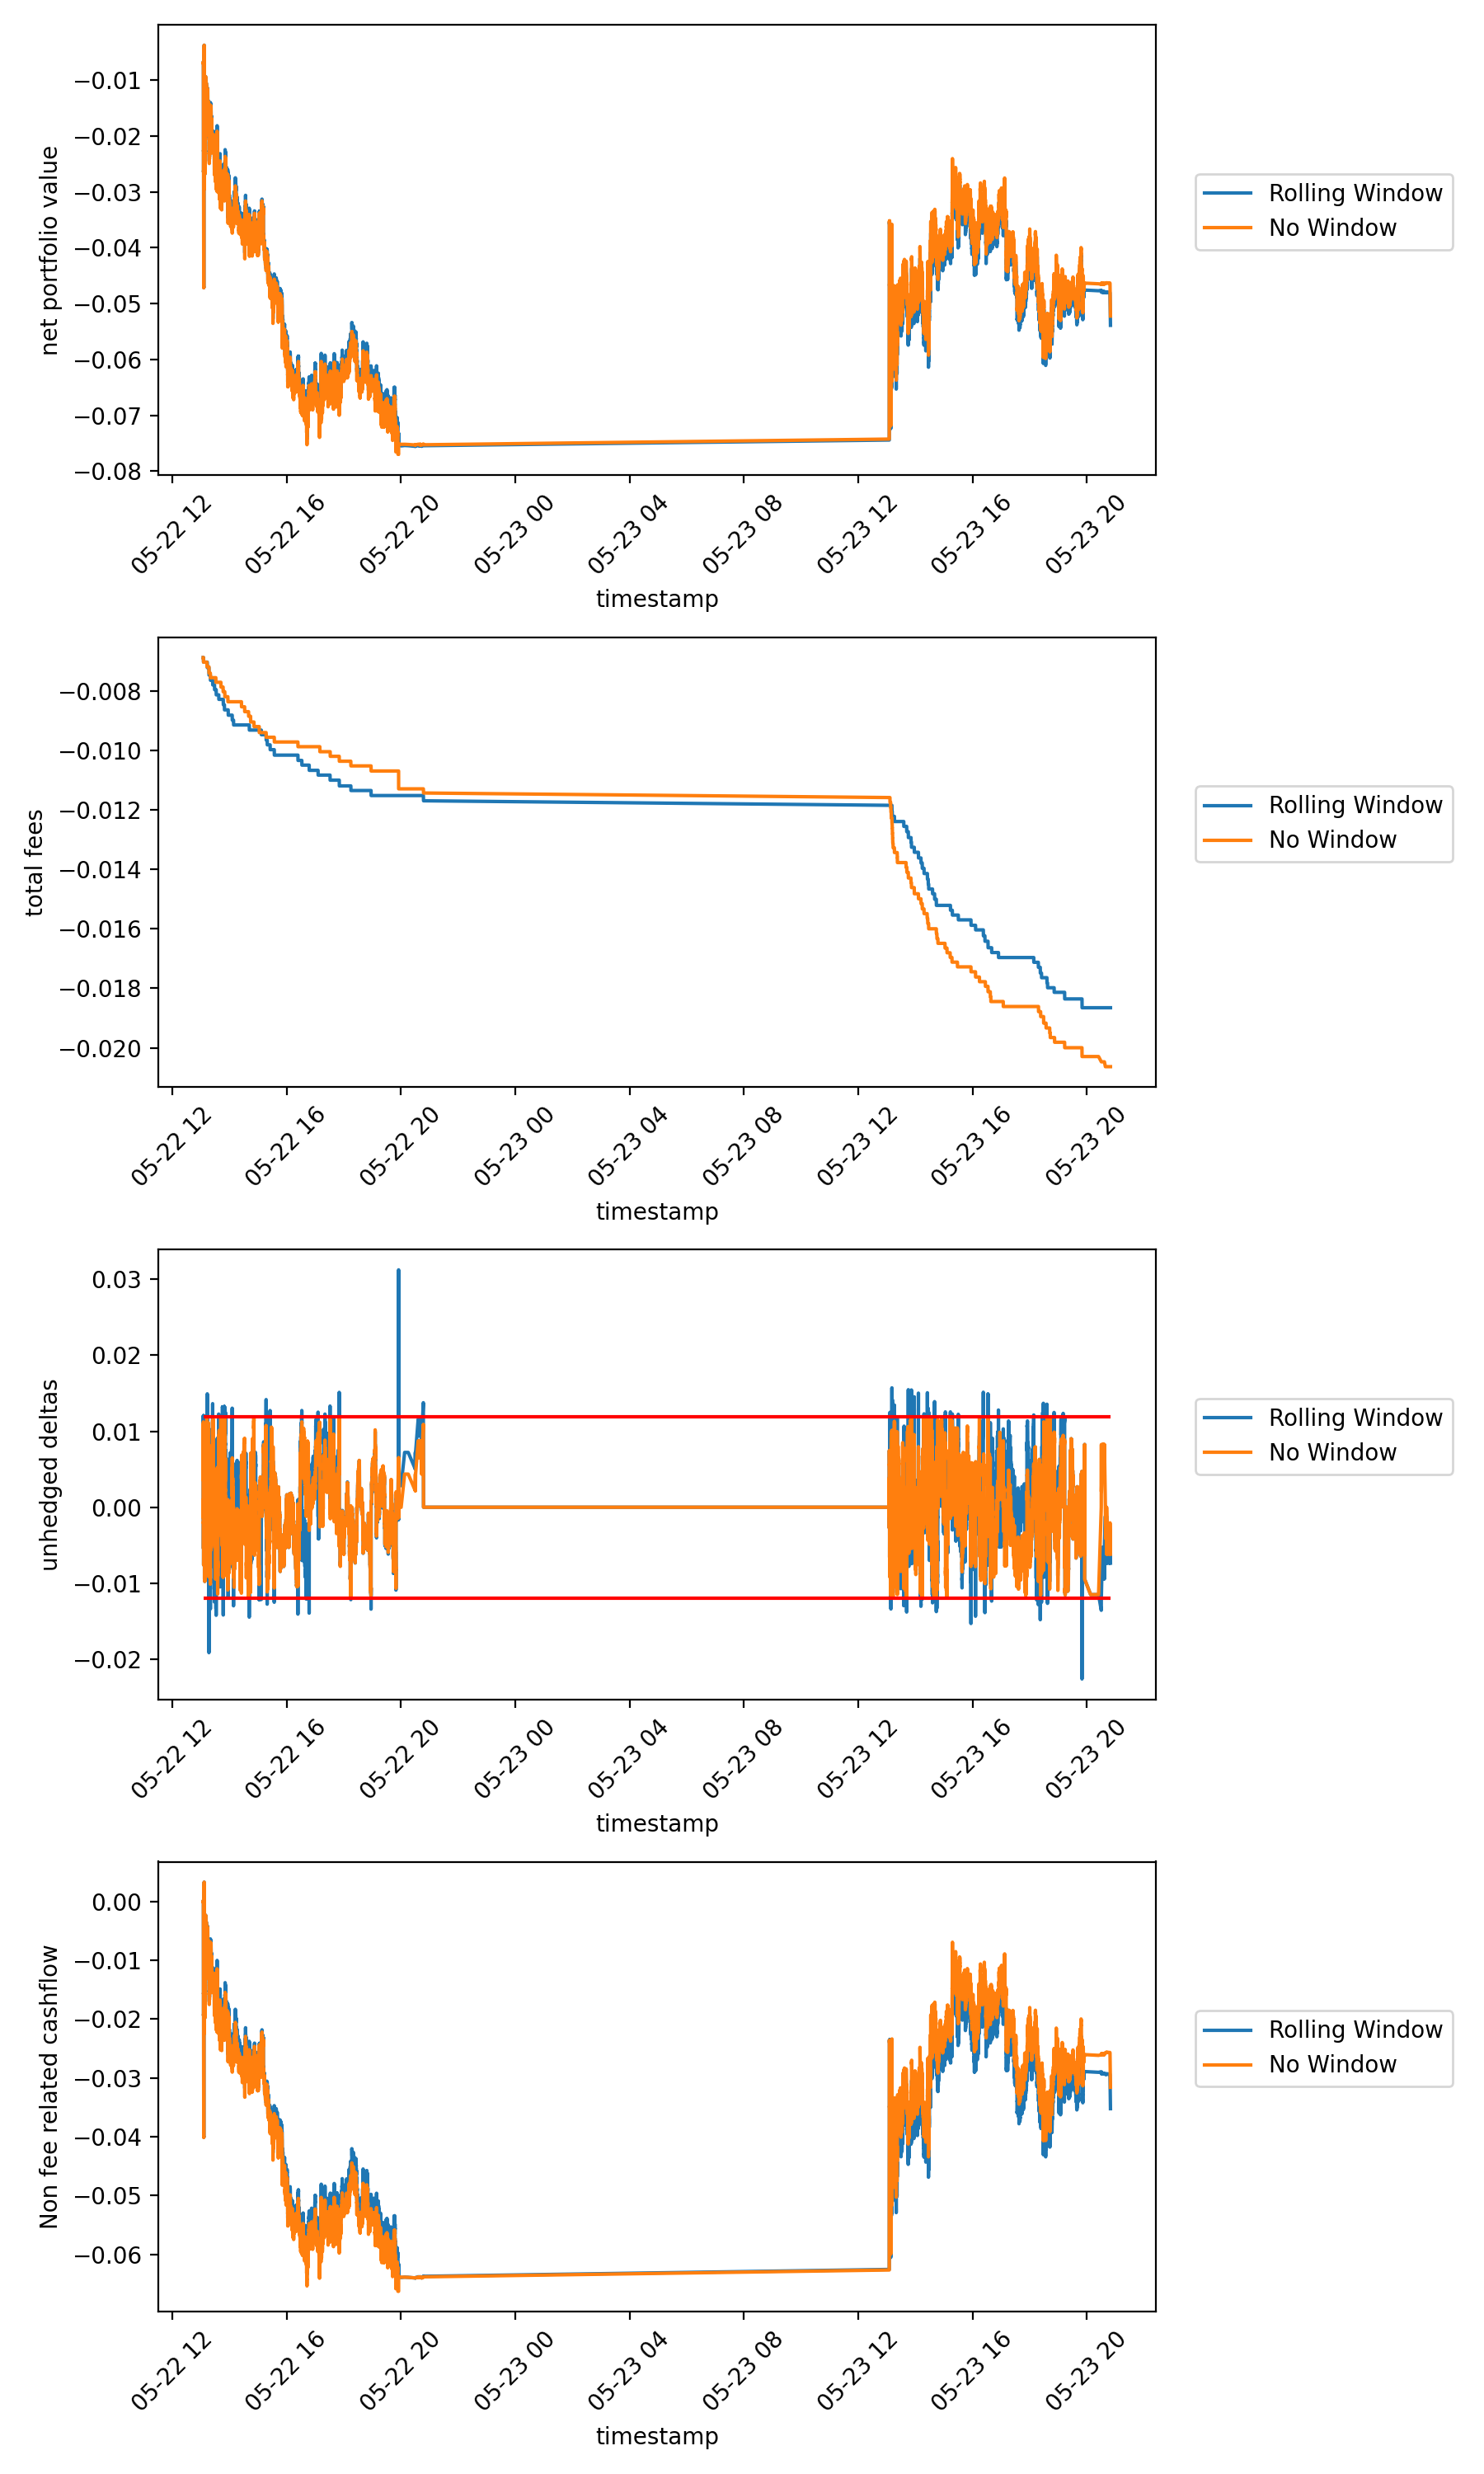

In [188]:
fig, axs = plt.subplots(4,1, figsize = (9,15))

axs[0].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_net_value'], label = 'Rolling Window')
axs[0].plot(cls.data.index, cls.data[f'{tol}tol_net_value'], label = 'No Window')
axs[0].set_ylabel('net portfolio value')

axs[1].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_tot_fees'], label = 'Rolling Window')
axs[1].plot(cls.data.index, cls.data[f'{tol}tol_tot_fees'], label = 'No Window')
axs[1].set_ylabel('total fees')

axs[2].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_exposure_arr'], label = 'Rolling Window')
axs[2].plot(cls.data.index, cls.data[f'{tol}tol_exposure_arr'], label = 'No Window')
axs[2].set_ylabel('unhedged deltas')
axs[2].hlines(y = tol, xmin = cls.data.index.min(), xmax = cls.data.index.max(), color = 'r')
axs[2].hlines(y = -tol, xmin = cls.data.index.min(), xmax = cls.data.index.max(), color = 'r')

axs[3].plot(cls.data.index, cls.data[f'{tol}:{window}delta_average_net_flow_exposure_arr'], label = 'Rolling Window')
axs[3].plot(cls.data.index, cls.data[f'{tol}tol_net_flow_exposure_arr'], label = 'No Window')
axs[3].set_ylabel('Non fee related cashflow')
    
for i in range(4):
    
    axs[i].tick_params(axis = 'x', rotation = 45)
    axs[i].set_xlabel('timestamp')
    axs[i].legend(loc = (1.04,0.5))

plt.tight_layout()

From the non fee related cash flow we see the rolling window does better in downwards markets and slightly worse in upward markets, this may be a consequence of the perfectly hedged position having correlation with the underlying.